In [38]:
%matplotlib inline
# to install watermark magic command: pip install ipyext
%load_ext watermark 
%watermark -v -p numpy,scipy,pandas,matplotlib,seaborn,sklearn

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
CPython 3.5.2
IPython 4.2.0

numpy 1.11.2
scipy 0.18.1
pandas 0.19.1
matplotlib 1.5.1
seaborn 0.7.1
sklearn 0.18.1


In [106]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import preprocessing
import make_geo_vars as mgv
import seaborn as sns

from pandas import set_option
set_option("display.max_rows",10)
pd.options.mode.chained_assignment = None

# turn off ipython warnings 
import warnings
warnings.filterwarnings('ignore')

filename = 'data/facies_vectors.csv'
training_data = pd.read_csv(filename)
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.100000,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.551500,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.300000,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


In [107]:
filename = 'data/validation_data_nofacies.csv'
test_data = pd.read_csv(filename)
test_data

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,A1 SH,STUART,2808.0,66.276,0.630,3.300,10.650,3.591,1,1.000
1,A1 SH,STUART,2808.5,77.252,0.585,6.500,11.950,3.341,1,0.978
2,A1 SH,STUART,2809.0,82.899,0.566,9.400,13.600,3.064,1,0.956
3,A1 SH,STUART,2809.5,80.671,0.593,9.500,13.250,2.977,1,0.933
4,A1 SH,STUART,2810.0,75.971,0.638,8.700,12.350,3.020,1,0.911
...,...,...,...,...,...,...,...,...,...,...
825,C SH,CRAWFORD,3158.5,86.078,0.554,5.040,16.150,3.161,1,0.639
826,C SH,CRAWFORD,3159.0,88.855,0.539,5.560,16.750,3.118,1,0.611
827,C SH,CRAWFORD,3159.5,90.490,0.530,6.360,16.780,3.168,1,0.583
828,C SH,CRAWFORD,3160.0,90.975,0.522,7.035,16.995,3.154,1,0.556


In [108]:
full_data = test_data.append(training_data.drop(['Facies'],axis=1))

In [109]:

from sklearn.preprocessing import StandardScaler, label_binarize

ss = StandardScaler()

explained variance ratio (first two components): [ 0.40157864  0.21914028]


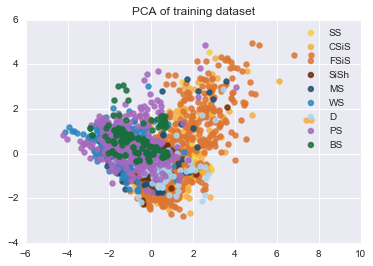

In [110]:
from sklearn.decomposition import PCA
idx = training_data['PE'].notnull()

X = (training_data[idx].drop(['Facies','Formation','Well Name','Depth','NM_M','GR'],axis=1)).values
y = training_data[idx]['Facies'].values
target_names = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS','WS', 'D','PS', 'BS']
X = ss.fit_transform(X)

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']
lw = 2

for color, i, target_name in zip(colors, range(1,10), target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of training dataset');

In [43]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import LeaveOneGroupOut
from sklearn import metrics
from sklearn import neighbors

logo = LeaveOneGroupOut()
svm = SVC(C=5)
clf = neighbors.KNeighborsClassifier(5, weights='distance')

In [115]:
scores=np.zeros((10,9))

names = training_data['Well Name'][idx].values

for j,(train, test) in zip(range(10),logo.split(X, y, groups=names)):

    clf.fit(X_r[train],y[train])
    y_pred = clf.predict(X_r[test])
   
    for F in range(1,10):

        y_test2 = [1 if yi==F else 0 for yi in y[test]]
        y_pred2 =[1 if yi==F else 0 for yi in y_pred]

        score = metrics.f1_score(y_test2, y_pred2)
#         w = sum(y_pred2)
        scores[j,F-1] = (score*w)



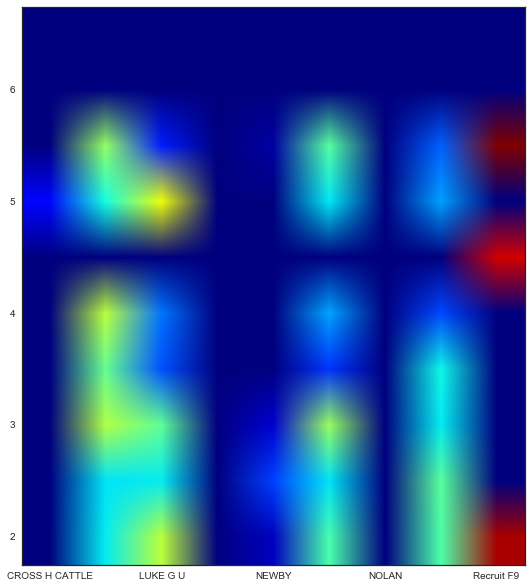

In [116]:
sns.set_style('white')
fig,ax = plt.subplots(figsize = (10,10))
im = ax.imshow(scores,cmap='jet')
ax.set_xticklabels(list(np.unique(names)))
ax.set_yticklabels(range(1,10))
ax.invert_yaxis()

In [18]:
eng_training_data = mgv.make_distance_to_M_down_vars(training_data)
eng_training_data = mgv.make_distance_to_NM_down_vars(eng_training_data)
eng_training_data = mgv.make_distance_to_M_up_vars(eng_training_data)
eng_training_data = mgv.make_distance_to_NM_up_vars(eng_training_data)
eng_training_data = mgv.make_rolling_marine_ratio_vars(eng_training_data,list(np.arange(5,50,5)))
eng_training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,...,dist_M_up,Marine_ratio_5_centered,Marine_ratio_10_centered,Marine_ratio_15_centered,Marine_ratio_20_centered,Marine_ratio_25_centered,Marine_ratio_30_centered,Marine_ratio_35_centered,Marine_ratio_40_centered,Marine_ratio_45_centered
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,...,-99999.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,...,-99999.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,...,-99999.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,...,-99999.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,...,-99999.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,...,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,...,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,...,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,...,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [102]:
X = np.zeros((len(X_r),6))
X[:,0]=eng_training_data[idx].dist_M_up.values
X[:,1]=eng_training_data[idx].dist_M_down.values
X[:,2]=eng_training_data[idx].NM_M.values
X[:,3]=eng_training_data[idx].GR.values
X[:,4:]=X_r

ss = StandardScaler()
X = ss.fit_transform(X)

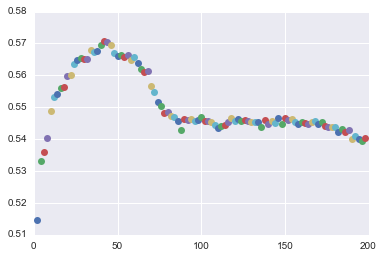

In [103]:
neighbours = np.arange(2,100,2)
fig,ax = plt.subplots()
for neighbour in neighbours:
    clf = neighbors.KNeighborsClassifier(neighbour, weights='distance')
    scores=[]
    names = training_data['Well Name'][idx].values
    for train, test in logo.split(X, y, groups=names):

        clf.fit(X[train],y[train])
        y_pred = clf.predict(X[test])



#         conf_mat = metrics.confusion_matrix(y[test],y_pred)
#         print(conf_mat)

        score = metrics.f1_score(y[test], y_pred,average='weighted')

        scores.append(score)
    #     print('********')
    #     print('Blind well is {0}, F1 score : {1:.4%}\n'.format(names[test[0]],score))


    ax.plot(neighbour,np.mean(scores),'o')
    # print("="*30)
    # print('*********** RESULT ***********')
    # print("="*30)
    # print('\nAverage  F1-score is {:.4%}'.format(np.mean(scores)))

In [49]:
X = (eng_training_data[idx].drop(['Facies','Formation','Well Name','Depth'],axis=1)).values
y = eng_training_data[idx]['Facies'].values

from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X = ss.fit_transform(X)


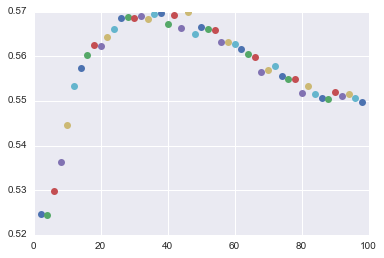

In [50]:
neighbours = np.arange(2,100,2)
fig,ax = plt.subplots()
for neighbour in neighbours:
    clf = neighbors.KNeighborsClassifier(neighbour, weights='distance')
    scores=[]
    names = training_data['Well Name'][idx].values
    for train, test in logo.split(X, y, groups=names):

        clf.fit(X[train],y[train])
        y_pred = clf.predict(X[test])



#         conf_mat = metrics.confusion_matrix(y[test],y_pred)
#         print(conf_mat)

        score = metrics.f1_score(y[test], y_pred,average='weighted')

        scores.append(score)
    #     print('********')
    #     print('Blind well is {0}, F1 score : {1:.4%}\n'.format(names[test[0]],score))


    ax.plot(neighbour,np.mean(scores),'o')
    # print("="*30)
    # print('*********** RESULT ***********')
    # print("="*30)
    # print('\nAverage  F1-score is {:.4%}'.format(np.mean(scores)))

In [126]:
from sklearn.model_selection import LeavePGroupsOut
lpgo = LeavePGroupsOut(n_groups=2)
from sklearn.ensemble import RandomForestClassifier

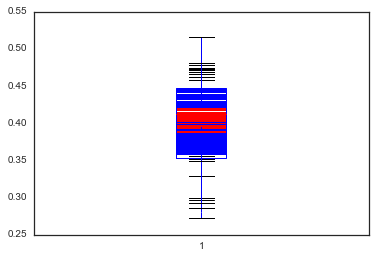

In [134]:
neighbours = np.arange(20,200,50)
fig,ax = plt.subplots()
for i,neighbour in zip(range(len(neighbours)),neighbours):
#     clf = neighbors.KNeighborsClassifier(neighbour, weights='distance')
    clf = RandomForestClassifier(n_estimators=neighbour,min_samples_leaf=10)
    scores=[]
    names = training_data['Well Name'][idx].values
    for train, test in lpgo.split(X, y, groups=names):

        clf.fit(X[train],y[train])
        y_pred = clf.predict(X[test])



#         conf_mat = metrics.confusion_matrix(y[test],y_pred)
#         print(conf_mat)

        score = metrics.f1_score(y[test], y_pred,average='weighted')

        scores.append(score)
    #     print('********')
    #     print('Blind well is {0}, F1 score : {1:.4%}\n'.format(names[test[0]],score))


#     ax.errorbar(neighbour,np.mean(scores),fmt='o',yerr=np.std(scores))
        ax.boxplot(scores)
    # print("="*30)
    # print('*********** RESULT ***********')
    # print("="*30)
    # print('\nAverage  F1-score is {:.4%}'.format(np.mean(scores)))

In [122]:
np.std(scores)

0.053761194945064067